In [17]:
import Zip
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
import math


# Channels in the detector
det_ch = { 'tpc': list(range(0, 247+1)), 'veto': list(range(248, 253+1)), 
          'sum_wv': [254], 'busy_on': [255], 'busy_off': [256],
          'hev_on': [257], 'hev_off': [258], 'muon_veto_trigger': [259], } 
n_channels = 260

# Initial parameters
baseline_ = 16384.0 * np.ones(n_channels)
std_ = 2.3 * np.ones(n_channels)

# The data files
NG = Zip.ReadZipped("/data/nikhefproject/data/xenon1t/NG") # Neutron data
Rn220 = Zip.ReadZipped("/data/nikhefproject/data/xenon1t/Rn220") # Rn-220 data

In [18]:
def process_waveform(pulse):
    """Very simple peakfinder. Returns a list of ch, pulse Q, width and start of pulse. 
    Q is in ADC counts and width and start of pulse are in sample counts relative to 
    start of event."""
    q, pe = 0, 0
    left_t, right_t = 0, 0
    ch = pulse.channel
    #if ch not in det_ch['tpc']:
    #    return (-1, 0, 0, 0)
        
    #ch = det_ch['tpc'].index(ch)
    wf = pulse.raw_data
    
    s = np.std(wf)
    delta = baseline_[ch] - np.min(wf)
    if min(s, delta) > 5*std_[ch]:
        accumulating = False
        first = True
        for samples in enumerate(wf):
            base_sub = samples[1]-baseline_[ch]
            #print(samples, " ", base_sub, " ", std, " ", q)
            if abs(base_sub) > 5*std_[ch] and samples[1] < 0.95*baseline_[ch]:
                q = q + base_sub
                if not accumulating and first:
                    left_t = samples[0]
                    accumulating = True
                    first = False
            else:
                if accumulating:
                    right_t = samples[0]
                    #accumulating = False
    else:
        baseline_[ch] = np.average(wf)
        std_[ch] = s
    width = right_t - left_t
    if width != 0 and -q/width < 3*std_[ch]:
        q = 0
#    if width != 0:
#        pe = q * 0.5/2**14 * 2 * 1e-9/(width * 1.6022e-19) * 2e-6 * -1
    return (ch, q, width, pulse.left+left_t)

In [19]:
%matplotlib inline
event = NG.get_single_event(5)

s1 = [0, 0]
s2 = [0, 0]
for p in event.pulses:
    (ch, q, width, t0) = process_waveform(p)
    if q < 0 and ch == 254:
        print(ch, ": ", q, width, t0)
        """
        if width < 1000: # Separate S1 from S2
            if s1[ch] == 0:
                s1[ch] = -q
            else:
                s2[ch] = s2[ch] - q # Sum all the S2
        """

254 :  -6626.0 68 100057
254 :  -456606.0 396 122277


In [20]:
# A waveform reader function
def Waveform(eventnr):
    event = NG.get_single_event(eventnr)
                                
    #The variables that check if a channel is the minimum channel
    adcmin = 16382
    minchannel = 0
    
    #A list that holds all the channels with significant pulses 
    channellist = []
    
    #Create the datapoint arrays
    n = 350000  
    ts = np.ones((n_channels, n), dtype=np.int16)
    ts = ts * 16382 
    t = np.linspace(0, n, n) 
    
    #Loop over all pulses in the event
    for p in event.pulses:
        ch = p.channel
        i = np.zeros(n_channels, dtype = int)
        #print(p.channel, ": ", p.left, p.right-p.left)
        for adc in p.raw_data:
            
            #Add the ADC value to the appropriate channel array
            ts[ch][p.left + i[ch]] = adc
            i[ch] = i[ch] + 1
            
            #Append all significant main channels to the list
            if adc < 15000 and ch not in channellist and ch in det_ch['tpc']:
                channellist.append(ch)
                
            #Check which channel is the minimum channel
            if adc < adcmin:
                adcmin = adc
                minchannel = ch
                
    #Sort for convenience
    channellist.sort()
    return t, ts, channellist, minchannel

127 :  -81142.8431373 464 122313
204 :  -66828.3529412 503 122340
181 :  -100739.25 450 122333
159 :  -14522.0392157 457 122307
146 :  -47998.0 515 122323
215 :  -145766.605769 405 122337
151 :  -40883.0 659 122353
96 :  -9689.0 290 122364
191 :  -10345.2254902 461 122406
180 :  -189448.0 454 122305
171 :  -19048.8 514 122355
177 :  -15937.3529412 333 122360
182 :  -18492.9607843 424 122354
169 :  -104677.586538 374 122331
147 :  -115624.769231 462 122313
238 :  -37470.5294118 385 122318
136 :  -33061.4615385 483 122333
186 :  -37851.3333333 556 122323
229 :  -64714.2307692 483 122334
138 :  -75614.5245902 393 122304
223 :  -44187.8823529 459 122320
90 :  -16271.1764706 449 122362
176 :  -7104.85294118 433 122365
218 :  -51630.0098039 353 122344
242 :  -14430.6923077 392 122375
212 :  -23910.5 461 122300
175 :  -89600.5288462 448 122329
221 :  -43492.1442308 400 122327
241 :  -22459.0 433 122317
51 :  -1652.0 232 122493
254 :  -6626.0 68 100057
0 :  -943938.361111 1180 122244
37 :  -22

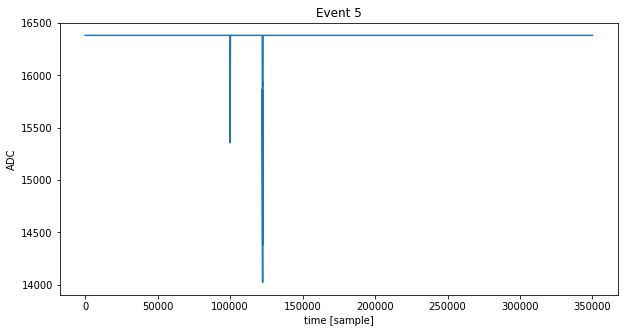

In [23]:
%matplotlib inline
event = NG.get_single_event(5)

t, ts, channellist, minchannel = Waveform(5)

figs, ax = plt.subplots(figsize = (10.,5.))
ax.plot(t, ts[254], label='Channel 254')
#ax[1].plot(t, ts[1], label='Bottom PMT', color='orange')
ax.set_ylabel("ADC")
#ax[1].set_ylabel("ADC")
ax.set_xlabel("time [sample]")
ax.set_title('Event ' + str(event.event_number))


for p in event.pulses:
    (ch, q, width, t0) = process_waveform(p)
    if q < 0:
        print(ch, ": ", q, width, t0)
        ax.add_patch(patches.Rectangle((p.left-1000, 0), width, 10000, color='grey', alpha=0.2))